In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =5e-25

nband = 80

ng =5

ng_adju = (/ 1 /) 

ng_refs = (/ 2 , 3 /) 

nref =2

nv = 1000

option_compute_btable =0

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 100 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =300

vstar = 720

data w_diffuse
     &     /1.55 , 1.6 , 1.66 , 1.66,
     &     1.8/

data wgt
     &     /0.5 , 0.5 , 0.6 , 0.7,
     &     0.9/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

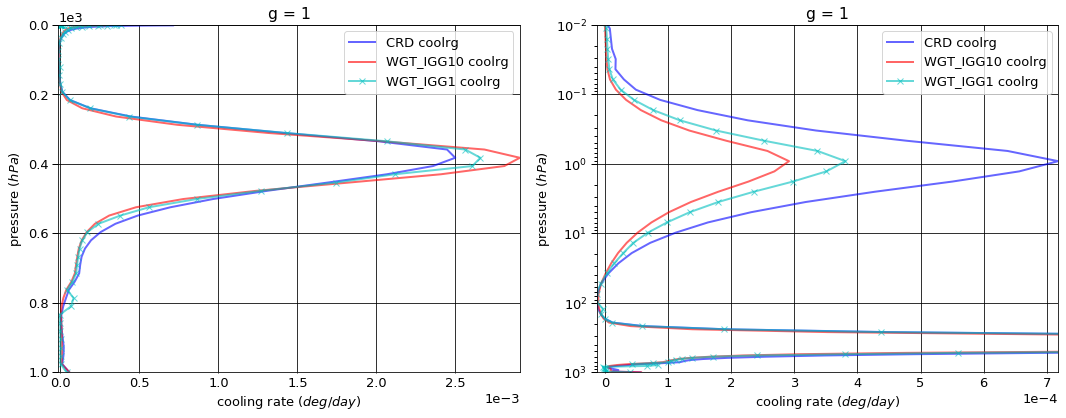

# Figure: cooling rate g-group 2

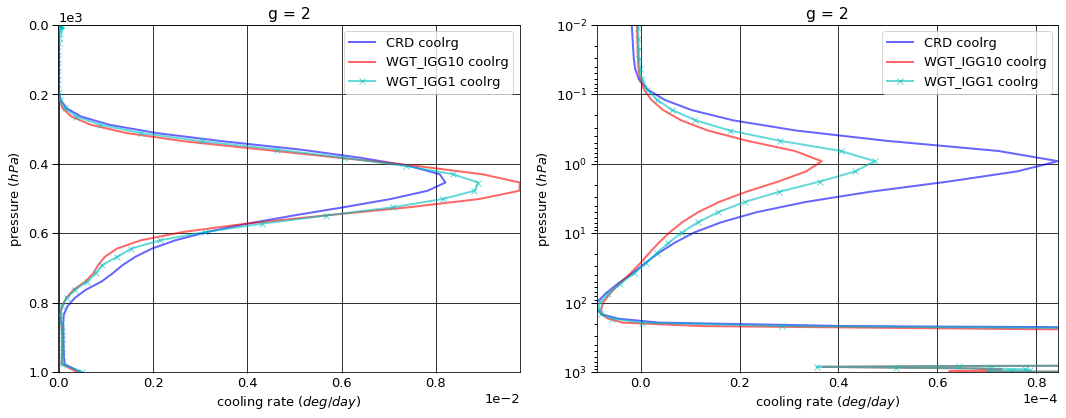

# Figure: cooling rate g-group 3

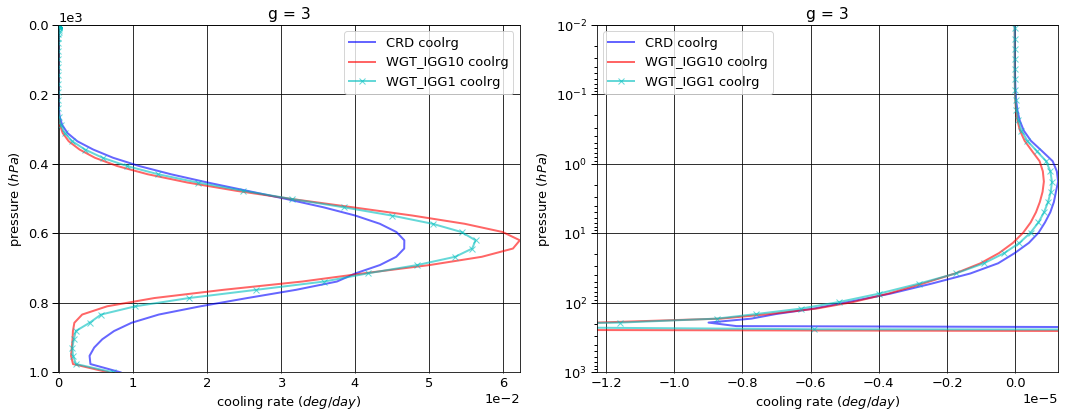

# Figure: cooling rate g-group 4

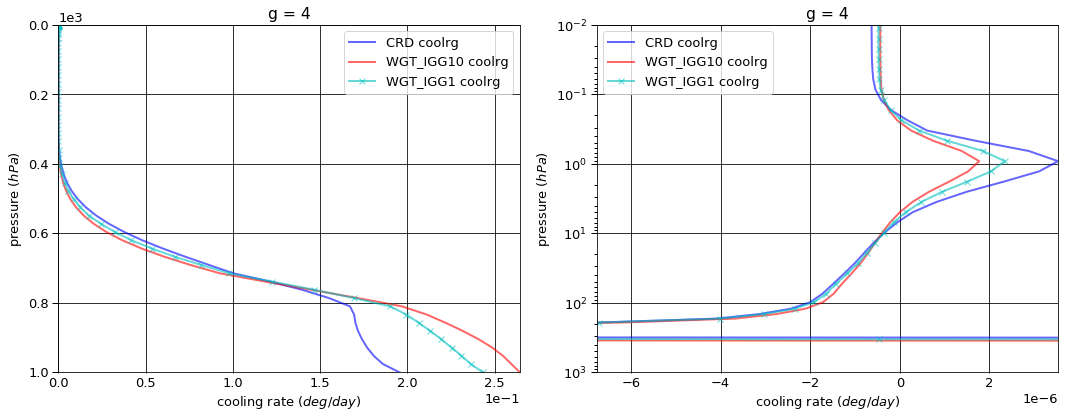

# Figure: cooling rate g-group 5

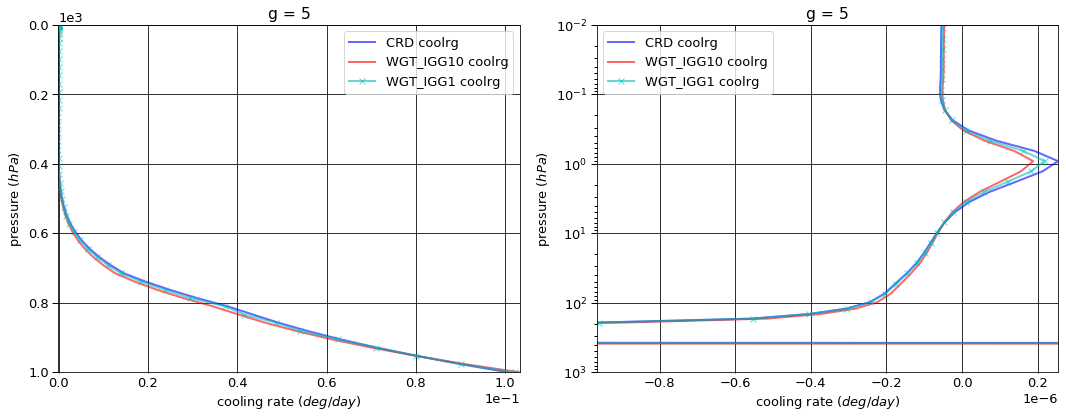

# Figure: cooling rate g-group total

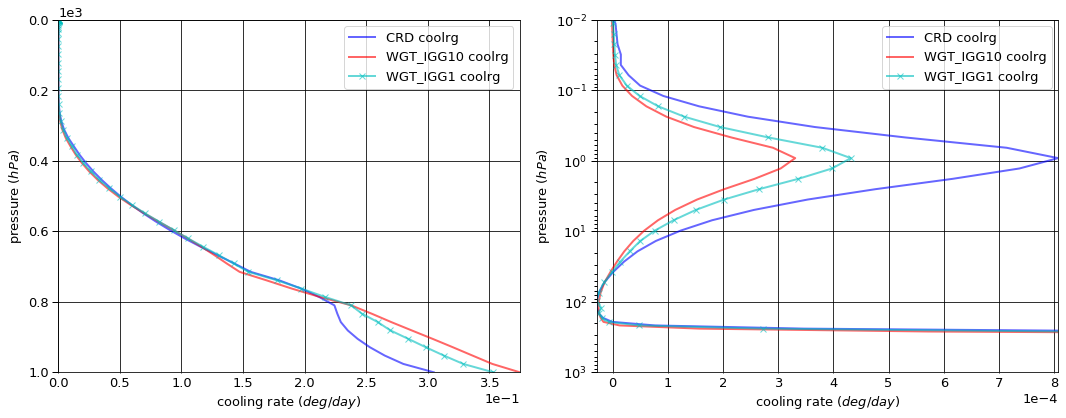

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.060186  0.000000  -0.060186
  1013.0   76     -0.129239  0.129088  -0.000151
2 0.0      1      -0.247423  0.000000  -0.247423
  1013.0   76     -0.460993  0.459633  -0.001360
3 0.0      1      -1.943072  0.000000  -1.943072
  1013.0   76     -2.824402  2.793406  -0.030996
4 0.0      1     -12.360079  0.000000 -12.360079
  1013.0   76    -13.670912  8.373162  -5.297750
5 0.0      1     -17.882201  0.000000 -17.882201
  1013.0   76    -18.137963  2.298507 -15.839456


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.060072  0.000000  -0.060072
  1013.0   76     -0.129239  0.129089  -0.000150
2 0.0      1      -0.247622  0.000000  -0.247622
  1013.0   76     -0.460993  0.459959  -0.001034
3 0.0      1      -1.914588  0.000000  -1.914588
  1013.0   76     -2.824402  2.805512  -0.018890
4 0.0      1     -12.339007  0.000000 -12.339007
  1013.0   76    -13.670912  9.685124  -3.985788
5 0.0      1     -17.903173  0.000000 -17.903173
  1013.0   76    -18.137963  2.195296 -15.942667


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.059709  0.000000  -0.059709
  1013.0   76     -0.129239  0.129130  -0.000110
2 0.0      1      -0.247330  0.000000  -0.247330
  1013.0   76     -0.460993  0.459707  -0.001287
3 0.0      1      -1.917809  0.000000  -1.917809
  1013.0   76     -2.824402  2.802441  -0.021961
4 0.0      1     -12.314902  0.000000 -12.314902
  1013.0   76    -13.670912  9.389920  -4.280992
5 0.0      1     -17.889874  0.000000 -17.889874
  1013.0   76    -18.137963  2.261010 -15.876953


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000115  0.000000  0.000115
  1013.0   76     0.000000  0.000001  0.000001
2 0.0      1     -0.000199  0.000000 -0.000199
  1013.0   76     0.000000  0.000325  0.000325
3 0.0      1      0.028484  0.000000  0.028484
  1013.0   76     0.000000  0.012107  0.012106
4 0.0      1      0.021072  0.000000  0.021072
  1013.0   76     0.000000  1.311962  1.311962
5 0.0      1     -0.020972  0.000000 -0.020972
  1013.0   76     0.000000 -0.103212 -0.103211


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000477  0.000000  0.000477
  1013.0   76     0.000000  0.000042  0.000042
2 0.0      1      0.000093  0.000000  0.000093
  1013.0   76     0.000000  0.000073  0.000073
3 0.0      1      0.025263  0.000000  0.025263
  1013.0   76     0.000000  0.009036  0.009035
4 0.0      1      0.045177  0.000000  0.045177
  1013.0   76     0.000000  1.016758  1.016758
5 0.0      1     -0.007673  0.000000 -0.007673
  1013.0   76     0.000000 -0.037497 -0.037497

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.042565e-06
  1001.112500 75     5.619690e-05
2 0.000312    1     -2.518006e-06
  1001.112500 75     4.757629e-04
3 0.000312    1     -1.316394e-08
  1001.112500 75     8.367793e-03
4 0.000312    1     -6.334780e-07
  1001.112500 75     1.954280e-01
5 0.000312    1     -5.134686e-08
  1001.112500 75     1.006704e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -4.737650e-06
  1001.112500 75     5.720170e-05
2 0.000312    1     -1.073626e-06
  1001.112500 75     3.963175e-04
3 0.000312    1     -1.665230e-08
  1001.112500 75     6.720962e-03
4 0.000312    1     -4.301320e-07
  1001.112500 75     2.644374e-01
5 0.000312    1     -4.414197e-08
  1001.112500 75     1.032629e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -4.364816e-06
  1001.112500 75     3.925929e-05
2 0.000312    1     -1.014067e-06
  1001.112500 75     4.873830e-04
3 0.000312    1     -1.730375e-08
  1001.112500 75     7.379152e-03
4 0.000312    1     -4.732653e-07
  1001.112500 75     2.432637e-01
5 0.000312    1     -4.755228e-08
  1001.112500 75     1.021757e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -6.950854e-07
  1001.112500 75     1.004798e-06
2 0.000312    1      1.444380e-06
  1001.112500 75    -7.944548e-05
3 0.000312    1     -3.488368e-09
  1001.112500 75    -1.646832e-03
4 0.000312    1      2.033460e-07
  1001.112500 75     6.900946e-02
5 0.000312    1      7.204891e-09
  1001.112500 75     2.592530e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.222511e-07
  1001.112500 75    -1.693761e-05
2 0.000312    1      1.503939e-06
  1001.112500 75     1.162008e-05
3 0.000312    1     -4.139811e-09
  1001.112500 75    -9.886410e-04
4 0.000312    1      1.602128e-07
  1001.112500 75     4.783573e-02
5 0.000312    1      3.794576e-09
  1001.112500 75     1.505270e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.492961,0.000000,-32.492961
1013.0,76,-35.223510,14.053796,-21.169714



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.464461,0.00000,-32.464461
1013.0,76,-35.223510,15.27498,-19.948529



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.429624,0.000000,-32.429624
1013.0,76,-35.223510,15.042208,-20.181302



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.0285,0.000000,0.028500
1013.0,76,0.0000,1.221184,1.221184



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.063337,0.000000,0.063337
1013.0,76,0.000000,0.988412,0.988412


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000007
1001.112500,75,0.304998



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.374875



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.353345



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,9.563570e-07
1001.112500,75,6.987672e-02



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000001
1001.112500,75,0.048347


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.003675,0.003665
2,0.013137,0.013045
3,0.080437,0.079972
4,0.388950,0.387357
5,0.513800,0.515961


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,6.158640e-22
2,6.642950e-23
3,1.195213e-23
4,5.001064e-25
5,3.765264e-26


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,6.158640e-22,NaN,0.003675,0.003665,0.003675,0.003665,100.0
2,6.642950e-23,0.107864,0.013137,0.013045,0.016813,0.016710,100.0
3,1.195213e-23,0.179922,0.080437,0.079972,0.097250,0.096682,600.0
4,5.001064e-25,0.041842,0.388950,0.387357,0.486200,0.484039,600.0
5,3.765264e-26,0.075289,0.513800,0.515961,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
